In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from analyze import * # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime
import pickle
from scipy.stats import norm
import shutil

%matplotlib inline

In [2]:
thresholds = get_thresholds(find_regular_run(18190))

In [6]:
acc, stat, sys = acceptance_3runs(18190, 18191, 18192, thresholds)

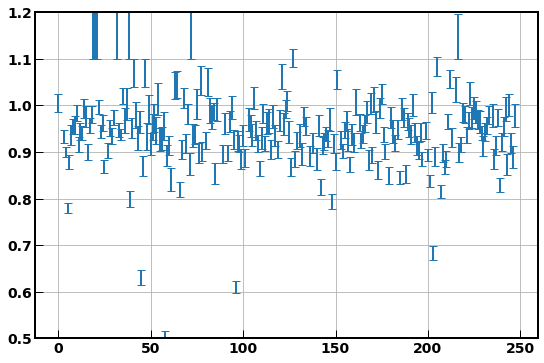

In [7]:
plt.figure(figsize=(9,6))
plt.errorbar(np.arange(248), acc, yerr=stat, linestyle='None')
plt.grid()
plt.ylim(0.5, 1.2)
plt.show()

In [10]:
data_dir_base = '/project/lgrandi/xenon1t/spe_acceptance/data'

def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

runlists = []
for runlist in os.listdir('runlists'):
    if all_data_exists(file_to_list(runlist)):
        runlists.append(runlist)

In [21]:
bottom_runs = []
acceptance = []
errs = []

for runlist in tqdm(runlists):
    l = file_to_list(runlist)
    
    if l[0] < 6846:
        continue
        #thresholds = np.load('selftrigger_thresholds_SR1_before6846.npz')['thresholds']
    
    elif 6846 < l[0] < 18000:
        thresholds = np.load('selftrigger_thresholds_SR1_after6846.npz')['thresholds']
    elif 18000 < l[0]:
        thresholds = get_thresholds(find_regular_run(l[0]))
        
    acc, stat, sys = acceptance_3runs(l[0], l[1], l[2], thresholds)
    
    bottom_runs.append(l[0])
    acceptance.append(acc)
    errs.append(stat)

    
acceptance = np.array(acceptance)
bottom_runs = np.array(bottom_runs)
errs = np.array(errs)

100%|██████████| 106/106 [12:45<00:00,  6.80s/it]


In [30]:
acc[:,0]

IndexError: too many indices for array

In [80]:
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import datetime

months = mdates.MonthLocator()
years = mdates.YearLocator()
datetimefmt = mdates.DateFormatter("%d-%m")


dates = [get_run_time(run) for run in bottom_runs]
today = datetime.date.today()


def plot_channel(ch):
    f, ax = plt.subplots(figsize=(8,5))
    ax.fmt_xdata = mdates.DateFormatter('%d-%m')
    ax.errorbar(dates, acceptance[:, ch], yerr=[errs[:,0,ch], errs[:,1,ch]], linestyle='None', 
                color='navy')
    ax.xaxis.set_major_formatter(datetimefmt)
    ax.xaxis.set_major_locator(months)
    plt.xlabel('Date')
    plt.ylabel('SPE Acceptance')
    plt.title('Channel %d' %ch)
    f.autofmt_xdate()
    plt.grid()
    plt.ylim(-0.1, 1.1)
    plt.xlim(datetime.date(year=2018, month=1, day=1), datetime.date(year=2018, month=5, day=1) )
    plt.savefig('plots/ch%d.png' % ch)
    plt.show()

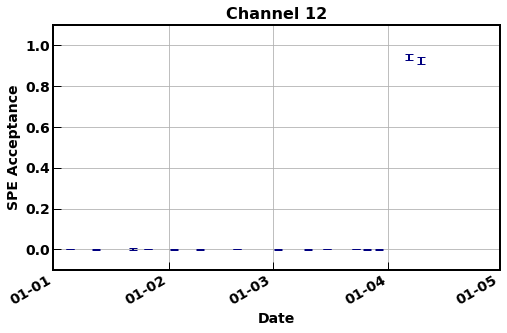

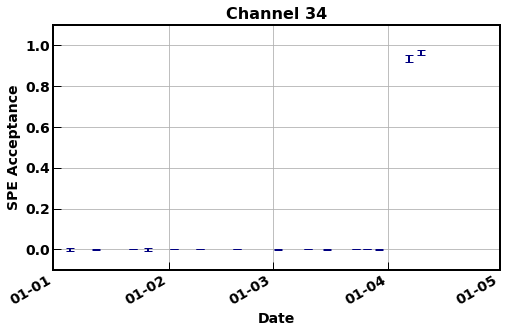

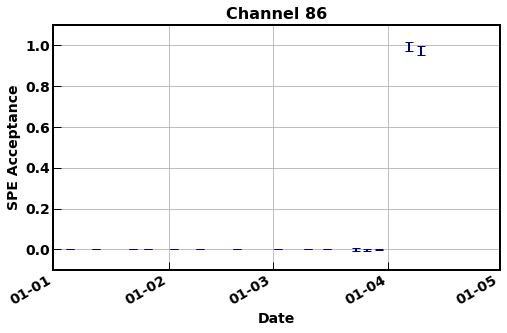

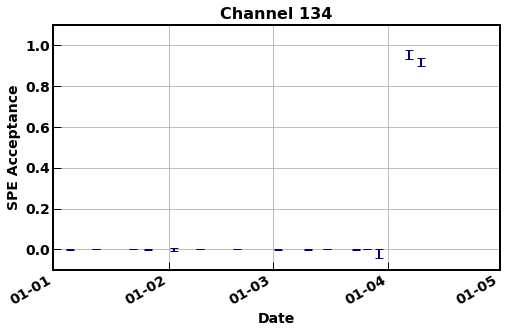

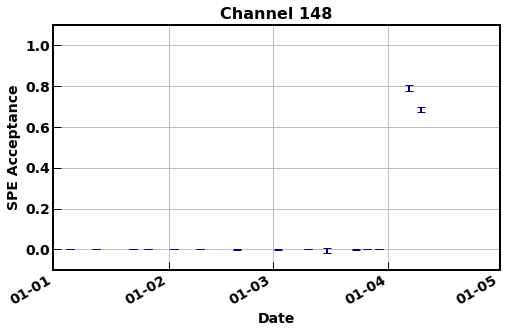

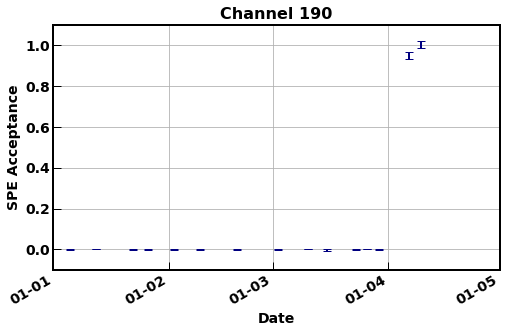

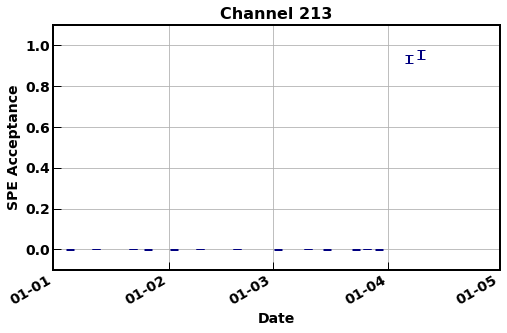

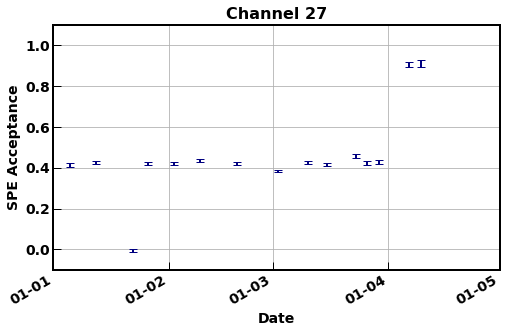

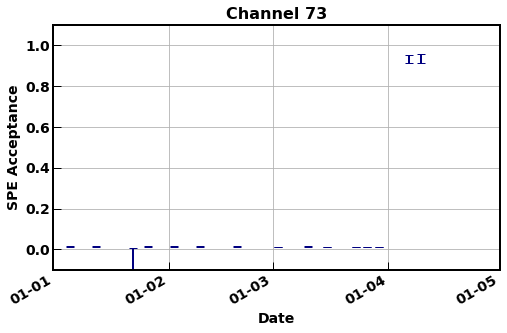

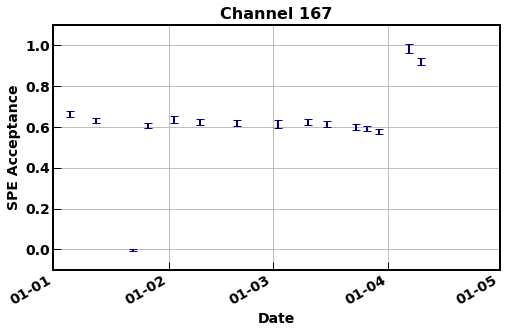

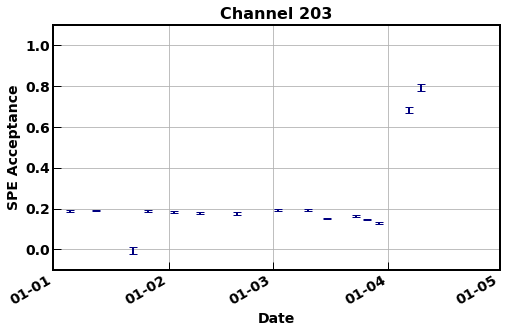

In [86]:
table = "^Channel^Acceptance^\n"

for ch in [12, 34, 86, 134, 148, 190, 213]:
    plot_channel(ch)
    indices = [dates.index(date) for date in sorted(dates)[-2:]]
    a = np.mean(acceptance[indices, ch])
    table += "|%d|%0.2f|\n" % (ch, a)

table2 = "^Channel^Acceptance^Uncertainty^\n"
for ch in [27, 73, 167, 203]:
    plot_channel(ch)
    indices = [dates.index(date) for date in sorted(dates)[-2:]]
    a = np.mean(acceptance[indices, ch])
    table2 += "|%d|%0.2f|\n" % (ch, a)

In [87]:
print(table)

print(table2)

^Channel^Acceptance^
|12|0.93|
|34|0.95|
|86|0.98|
|134|0.94|
|148|0.74|
|190|0.98|
|213|0.94|

^Channel^Acceptance^Uncertainty^
|27|0.91|
|73|0.93|
|167|0.95|
|203|0.74|

